## Data Preperation
1. The dataframe are to be split into training set and testing set using 80/20 split.
2. The columns with a large amount of missing values are dropped
3. The columns with a small amount of missing values are replaced with the mode value of the feature
4. The categorical data have dummy variables made for regression model
5. Normalize the data to have the same scale

In [4]:
## 1. Split the dataframe 
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size= .20, random_state= 420)

In [13]:
# 2. Remove columns with too many missing values
training_prepped = X_train.drop(drop_list, axis = 1)
testing_prepped = X_test.drop(drop_list, axis = 1)

In [14]:
# 3. Fill remaining missing values 
missing_train = {}
missing_test = {}

for columns in training_prepped:
    missing_train[columns] = training_prepped[columns].mode().values[0]
for columns in testing_prepped:
    missing_test[columns] = testing_prepped[columns].mode().values[0]
    
training_prepped.fillna(missing_train, inplace= True)
testing_prepped.fillna(missing_test, inplace = True)

In [15]:
# 4. Create dummy values for the string object datatype
training_prepped = pd.get_dummies(training_prepped)
testing_prepped = pd.get_dummies(testing_prepped)

In [16]:
# 5. Scaler to normalize the dateframe
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(training_prepped), columns= training_prepped.columns)
X_test_scaled = pd.DataFrame(scaler.transform(testing_prepped), columns= testing_prepped.columns)

## Baseline Regression Model - Decision Tree

The baseline regression model I used was a Decision Tree. Majority of the parameters wasn't changed and a random state was set to allow reproductivity. 

In [17]:
tree_clf = DecisionTreeClassifier(criterion= 'entropy', random_state= 420)
tree_model = tree_clf.fit(X_train_scaled,y_train)

tree_scores = []
tree_scores.append(tree_clf.score(X_train_scaled, y_train))
tree_scores.append(tree_clf.score(X_test_scaled, y_test))
tree_scores.append(cross_val_score(tree_clf, X_test_scaled, y_test, scoring= 'accuracy').mean())

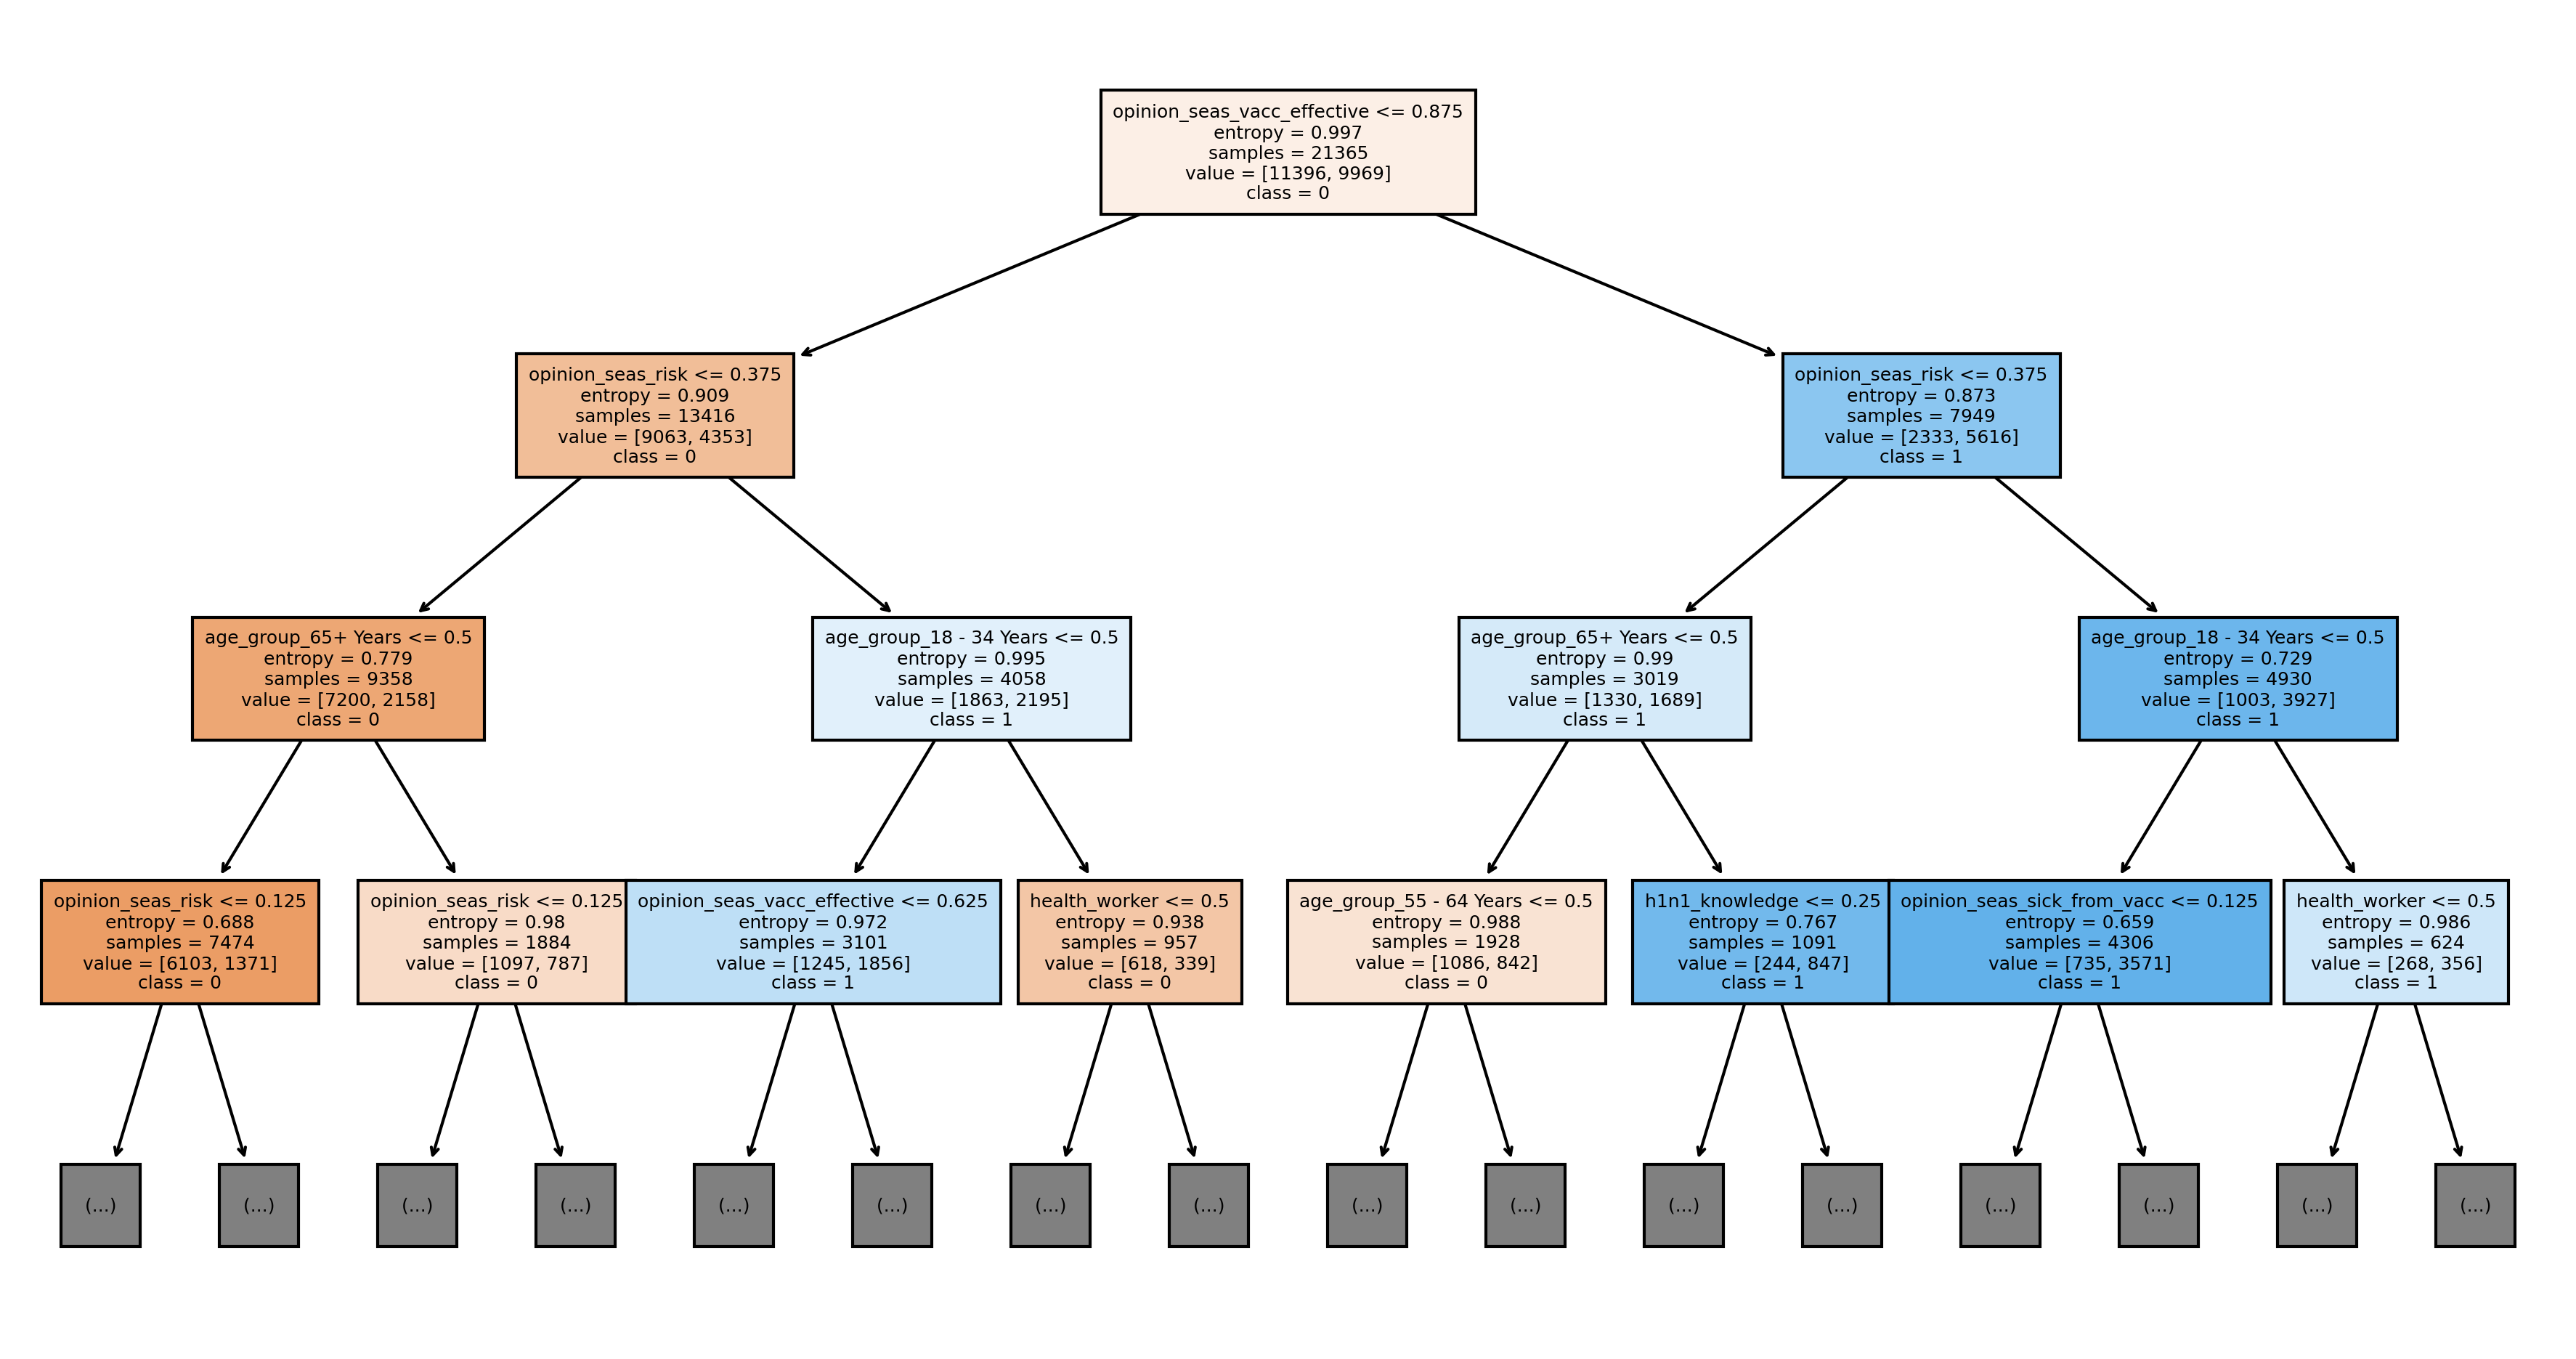

In [13]:
fig, axes = plt.subplots(nrows = 1,ncols = 1, figsize = (15,8), dpi=300)
tree.plot_tree(tree_clf,
               feature_names = X_train_scaled.columns, 
               class_names=np.unique(y_train).astype('str'),
               filled = True, 
               max_depth= 3, 
               fontsize = 6)
plt.show()

## Complex Regression Model - Random Forest Tree

In [69]:
forest_clf = RandomForestClassifier(criterion= 'entropy', max_depth= 10, max_features= None, random_state= 420)
forest_clf.fit(X_train_scaled,y_train)

forest_scores = []
forest_scores.append(forest_clf.score(X_train_scaled, y_train))
forest_scores.append(forest_clf.score(X_test_scaled, y_test))
forest_scores.append(cross_val_score(forest_clf, X_test_scaled, y_test, scoring= 'accuracy').mean())

In [15]:
# Original parameter grid to find the best parameters
# Model generation was used once with these parameters but was commented out due to length of processing the model and fitting it to the dataset
# param_grid = {
#                 'n_estimators' : [10, 30, 100, 300],
#                 'criterion': ['gini', 'entropy'],
#                 'max_depth' : [None, 2,3,4,5,6, 10],
#                 'min_samples_split' : [2,5,10, None],
#                 'min_samples_leaf' : [1,2,3,4,5,6, None],
#                 'max_features' : ['sqrt', 10, 20, 30, None]
#              }
# forest_clf = RandomForestClassifier()
# forest_grid_search = GridSearchCV(forest_clf, param_grid, return_train_score= True, cv= 3)
# forest_grid_search.fit(X_train_scaled, y_train)

# Used to load the model after finding the best model
with open('hyperparameter_model.pkl', 'rb') as f:
     forest_grid_search = joblib.load(f)

In [16]:
grid_scores = []
grid_scores.append(forest_grid_search.score(X_train_scaled, y_train))
grid_scores.append(forest_grid_search.score(X_test_scaled, y_test))

In [17]:
# Best Parameters from the grid search 

forest_grid_search = RandomForestClassifier(criterion = 'entropy',
                                    max_depth = None,
                                    max_features = 10,
                                    min_samples_leaf = 6,
                                    min_samples_split = 5,
                                    n_estimators = 300,
                                    random_state= 420)

forest_grid_search.fit(X_train_scaled, y_train)
grid_scores = []
grid_scores.append(forest_grid_search.score(X_train_scaled, y_train))
grid_scores.append(forest_grid_search.score(X_test_scaled, y_test))
grid_scores.append(cross_val_score(forest_grid_search, X_test_scaled, y_test, scoring= 'accuracy').mean())


In [18]:
# with open('hyperparameter_model_v2.pkl', 'wb') as f:
#     joblib.dump(forest_grid_search, f)

In [145]:
forest_grid_search.best_params_

AttributeError: 'RandomForestClassifier' object has no attribute 'best_params_'

In [20]:
for name, score in zip(['Decision Tree', 'Random Forest', 'Random Forest with Tuning']
                       ,[tree_scores]):
    
    print(f'{name} Model')
    print('Training Accuracy Score: {}'.format(score[0]))
    print('Testing Accuracy Score: {}'.format(score[1]))
    print('Cross Validation Score Mean: {} \n'.format(score[2]))

Decision Tree Model
Training Accuracy Score: 0.9999063889538966
Testing Accuracy Score: 0.6542493448146761
Cross Validation Score Mean: 0.6574268716956938 



In [ ]:
for column in X_test_scaled.columns:
    display(X_train_scaled[column].value_counts())

In [24]:
boost_clf = XGBClassifier()
boost_clf.fit(X_train_scaled, y_train)
boost_clf.score(X_test_scaled, y_test)

0.7482216398352677

In [23]:
X_train_scaled.columns = X_train_scaled.columns.str.translate("".maketrans({"[":"{", "]":"}","<":"^"}))
X_test_scaled.columns = X_test_scaled.columns.str.translate("".maketrans({"[":"{", "]":"}","<":"^"}))

In [26]:
param_grid = {
                'n_estimators' : [100, 200, 300],
                'max_depth' : [None, 1, 5, 10, 15],
                'learning_rate' : [.1, .2, .3],
                'min_child_weight': [1, 2],
                'subsample': [0.5, 0.7, 1],
                }
                               
                
boost_clf = XGBClassifier()
boost_search = GridSearchCV(boost_clf, param_grid, return_train_score= True, cv= 3, scoring= 'accuracy')
boost_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs...
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameters=None,
                                     verbosity=None),
             param_grid={'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth': [None, 1, 5, 10, 15],
                         'min_child_weight': [1, 2],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.5, 0.7, 1]},
             return_train_score=True, scoring='accuracy')

In [29]:
boost_search.score(X_test_scaled, y_test)
boost_search.score(X_train_scaled, y_train)

0.7908261174818628

In [ ]:
# with open('XGB.pkl', 'wb') as f:
#     joblib.dump(boost_search, f)

In [ ]:
for key in missing_labels:
    print(np.random.choice(missing_labels[key][0], p = missing_labels[key][1]))
    


In [ ]:
for column in X_train_v2.columns[1:]:
    display(X_train_v2[column].value_counts(normalize= True))

In [ ]:
for column in X_test_scaled.columns:
    display(X_train_scaled[column].value_counts(normalize= True))

## All Columns

## Data Preperation

In [121]:
# Create a copy with the pre prepared training and testing dataset
X_train_v2 = X_train.copy()
X_test_v2 = X_test.copy()

# Prepare the data as usual
for dataset in [X_train_v2, X_test_v2]:
    missing_labels = {}
    # Drop respondent id 
    dataset.drop('respondent_id', axis = 1, inplace= True)
    # Determing the probability of a given value in a given column
    for column in dataset.columns:
        if dataset[column].isna().sum() > 0:
            counts = dataset[column].value_counts(normalize= True)
            missing_labels[column] = [counts.keys(), counts.values]
    # For each of the missing columns, give the missing value a random value
    for column in missing_labels:
        indexs = dataset[column].loc[dataset[column].isna() == True].index
        values = np.random.choice(missing_labels[column][0], p = missing_labels[column][1], size = len(indexs))
        na_map = dict(zip(indexs, values))
        dataset[column].fillna(na_map, inplace= True)

# Create dummy variables
X_train_v2 = pd.get_dummies(X_train_v2)
X_test_v2 = pd.get_dummies(X_test_v2)

# Fit and transform the dataset with the dataset
X_train_scaled_v2 = pd.DataFrame(scaler.fit_transform(X_train_v2), columns= X_train_v2.columns)
X_test_scaled_v2 = pd.DataFrame(scaler.transform(X_test_v2), columns= X_test_v2.columns)

## Baseline Regression Model - Decision Tree V2

In [124]:
tree_clf = DecisionTreeClassifier(criterion= 'entropy', random_state= 420)
tree_model = tree_clf.fit(X_train_scaled_v2, y_train)

tree_scores_v2 = []
tree_scores_v2.append(tree_clf.score(X_train_scaled_v2, y_train))
tree_scores_v2.append(tree_clf.score(X_test_scaled_v2, y_test))
tree_scores_v2.append(cross_val_score(tree_clf, X_test_scaled_v2, y_test, scoring= 'accuracy').mean())

## Complex Regression Model - Random Forest Tree

In [131]:
forest_clf = RandomForestClassifier(criterion= 'entropy', max_depth= 10, max_features= None, random_state= 420)
forest_clf.fit(X_train_scaled_v2, y_train)

forest_scores_v2 = []
forest_scores_v2.append(forest_clf.score(X_train_scaled_v2, y_train))
forest_scores_v2.append(forest_clf.score(X_test_scaled_v2, y_test))
forest_scores_v2.append(cross_val_score(forest_clf, X_test_scaled_v2, y_test, scoring= 'accuracy').mean())

## Complex Regression Model - Random Forest Tree

In [ ]:
# Original parameter grid to find the best parameters
# Model generation was used once with these parameters but was commented out due to length of processing the model and fitting it to the dataset
param_grid = {
                'n_estimators' : [10, 30, 100, 300],
                'criterion': ['gini', 'entropy'],
                'max_depth' : [None, 2,3,4,5,6, 10],
                'min_samples_split' : [2,5,10],
                'min_samples_leaf' : [1,2,3,4,5,6],
                'max_features' : ['sqrt', 10, 20, 30, None]
             }

# {'criterion': 'entropy',
#  'max_depth': None,
#  'max_features': 10,
#  'min_samples_leaf': 2,
#  'min_samples_split': 5,
#  'n_estimators': 300}

# {'criterion': 'entropy',
#  'max_depth': None,
#  'max_features': 15,
#  'min_samples_leaf': 1,
#  'min_samples_split': 4,
#  'n_estimators': 300}

forest_clf = RandomForestClassifier()
forest_grid_search_v2 = GridSearchCV(forest_clf, param_grid, return_train_score= True, cv= 3)
forest_grid_search_v2.fit(X_train_scaled_v2, y_train)

grid_scores = []
grid_scores.append(forest_grid_search_v2.score(X_train_scaled_v2, y_train))
grid_scores.append(forest_grid_search_v2.score(X_test_scaled_v2, y_test))

In [138]:
grid_scores_v2 = []
grid_scores_v2.append(forest_grid_search_v2.score(X_train_scaled_v2, y_train))
grid_scores_v2.append(forest_grid_search_v2.score(X_test_scaled_v2, y_test))

In [139]:
print('Version 2 with all columns available')
for name, score in zip(['Decision Tree', 'Random Forest', 'Random Forest with Tuning']
                       ,[tree_scores_v2, forest_scores_v2, grid_scores_v2]):
    print(f'{name} Model')
    print('Training Accuracy Score: {}'.format(score[0]))
    print('Testing Accuracy Score: {}'.format(score[1]))
    print('Cross Validation Score Mean: {} \n'.format(score[2]))

Version 2 with all columns available
Decision Tree Model
Training Accuracy Score: 1.0
Testing Accuracy Score: 0.6830774990640209
Cross Validation Score Mean: 0.6793299769114614 

Random Forest Model
Training Accuracy Score: 0.8342616428738591
Testing Accuracy Score: 0.7804193186072632
Cross Validation Score Mean: 0.7646945060489168 

Random Forest with Tuning Model
Training Accuracy Score: 0.9554411420547625
Testing Accuracy Score: 0.7821040808685885


IndexError: list index out of range

In [140]:
forest_grid_search_v2.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'max_features': 10,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 300}

In [165]:
param_grid = {
                'n_estimators' : [300],
                'criterion': ['entropy'],
                'max_depth' : [None],
                'min_samples_split' : [4, 5, 6 ,7, 8, 9],
                'min_samples_leaf' : [1, 2, 3, 4, 5, 6],
                'max_features' : ['sqrt', 13, 14,15, 16, None]
             }

In [166]:
forest_clf = RandomForestClassifier()
forest_grid_search_v2 = GridSearchCV(forest_clf, param_grid, return_train_score= True, cv= 3)
forest_grid_search_v2.fit(X_train_scaled_v2, y_train)

grid_scores = []
grid_scores.append(forest_grid_search_v2.score(X_train_scaled_v2, y_train))
grid_scores.append(forest_grid_search_v2.score(X_test_scaled_v2, y_test))

In [167]:
print('Version 2 with all columns available')
for name, score in zip(['Decision Tree', 'Random Forest', 'Random Forest with Tuning']
                       ,[tree_scores_v2, forest_scores_v2, grid_scores]):
    print(f'{name} Model')
    print('Training Accuracy Score: {}'.format(score[0]))
    print('Testing Accuracy Score: {}'.format(score[1]))
    print('Cross Validation Score Mean: {} \n'.format(score[2]))

Version 2 with all columns available
Decision Tree Model
Training Accuracy Score: 1.0
Testing Accuracy Score: 0.6830774990640209
Cross Validation Score Mean: 0.6793299769114614 

Random Forest Model
Training Accuracy Score: 0.8342616428738591
Testing Accuracy Score: 0.7804193186072632
Cross Validation Score Mean: 0.7646945060489168 

Random Forest with Tuning Model
Training Accuracy Score: 0.9980341680318278
Testing Accuracy Score: 0.7813552976413328


IndexError: list index out of range

In [168]:
forest_grid_search_v2.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'max_features': 15,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 300}

In [75]:
tree_clf = DecisionTreeClassifier(criterion= 'entropy', random_state= 420)
forest_clf = RandomForestClassifier(criterion= 'entropy', max_depth= 10, max_features= None, random_state= 420)
forest_clf_v2 = RandomForestClassifier(random_state= 420)



In [138]:
pipelines = {}
scaler = MinMaxScaler()
col_transformer = ColumnTransformer(transformers=[
    ("ohe", OneHotEncoder(categories="auto", handle_unknown="ignore"), list(features.select_dtypes(object).columns))
], remainder="passthrough")

pipeline = Pipeline(steps = [ ('dummiers', col_transformer),
                              ('scaler', scaler)])
                        


In [26]:
## 1. Split the dataframe 
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size= .20, random_state= 420)

## 1. Column Removal

### Baseline Regression Model - Decision Tree


In [139]:
X_train_1 = X_train.copy()
X_test_1 = X_test.copy()
for dataset in [X_train_1, X_test_1]:
    
    # 2. Remove columns with too many missing values
    dataset.drop(drop_list, axis = 1, inplace = True)
    # 3. Fill remaining missing values 
    missing_value_mode = {}
    for columns in dataset:
        missing_value_mode[columns] = dataset[columns].mode().values[0]
    
    dataset.fillna(missing_value_mode, inplace= True)
    


In [140]:
X_train_1_scaled = pipeline.fit_transform(X_train_1, y_train)
X_test_1_scaled = pipeline.transform(X_test_1)

ValueError: A given column is not a column of the dataframe

In [117]:
tree_clf = DecisionTreeClassifier(criterion= 'entropy', random_state= 420)
tree_model = tree_clf.fit(X_train_1_scaled,y_train)

tree_scores = []
tree_scores.append(tree_clf.score(X_train_1_scaled, y_train))
tree_scores.append(tree_clf.score(X_test_1_scaled, y_test))
tree_scores.append(cross_val_score(tree_clf, X_test_1_scaled, y_test, scoring= 'accuracy').mean())

### Complex Regression Model - Random Forest Tree

In [123]:
forest_clf = RandomForestClassifier(criterion= 'entropy', max_depth= 10, max_features= None, random_state= 420)
forest_clf.fit(X_train_1_scaled,y_train)

forest_scores = []
forest_scores.append(forest_clf.score(X_train_1_scaled, y_train))
forest_scores.append(forest_clf.score(X_test_1_scaled, y_test))
forest_scores.append(cross_val_score(forest_clf, X_test_1_scaled, y_test, scoring= 'accuracy').mean())

### Tuned Regression Model - Random Forest

In [125]:
# Best Parameters from the grid search 

forest_grid_search = RandomForestClassifier(criterion = 'entropy',
                                    max_depth = None,
                                    max_features = 10,
                                    min_samples_leaf = 6,
                                    min_samples_split = 5,
                                    n_estimators = 300,
                                    random_state= 420)

forest_grid_search.fit(X_train_scaled, y_train)
grid_scores = []
grid_scores.append(forest_grid_search.score(X_train_scaled, y_train))
grid_scores.append(forest_grid_search.score(X_test_scaled, y_test))
grid_scores.append(cross_val_score(forest_grid_search, X_test_scaled, y_test, scoring= 'accuracy').mean())


In [126]:
for name, score in zip(['Decision Tree', 'Random Forest', 'Random Forest with Tuning']
                       ,[tree_scores, forest_scores, grid_scores]):
    
    print(f'{name} Model')
    print('Training Accuracy Score: {}'.format(score[0]))
    print('Testing Accuracy Score: {}'.format(score[1]))
    print('Cross Validation Score Mean: {} \n'.format(score[2]))

Decision Tree Model
Training Accuracy Score: 0.9999063889538966
Testing Accuracy Score: 0.6516286035192812
Cross Validation Score Mean: 0.6658496337015587 

Random Forest Model
Training Accuracy Score: 0.8228879007722911
Testing Accuracy Score: 0.7536503182328715
Cross Validation Score Mean: 0.7500921439407475 

Random Forest with Tuning Model
Training Accuracy Score: 0.8377720571027382
Testing Accuracy Score: 0.7622613253463122
Cross Validation Score Mean: 0.7572070225594993 



## 1. Index Removal

In [132]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(features.drop(index = index_drop, axis = 0), target.drop(index = index_drop), test_size= .20, random_state= 420)
X_train_2_scaled = pipeline.fit_transform(X_train_2, y_train_2)
X_test_2_scaled = pipeline.transform(X_test_2)

tree_clf = DecisionTreeClassifier(criterion= 'entropy', random_state= 420)
tree_model = tree_clf.fit(X_train_2_scaled,y_train)

tree_scores_2 = []
tree_scores_2.append(tree_clf.score(X_train_2_scaled, y_train))
tree_scores_2.append(tree_clf.score(X_test_2_scaled, y_test))
tree_scores_2.append(cross_val_score(tree_clf, X_test_2_scaled, y_test, scoring= 'accuracy').mean())

ValueError: could not convert string to float: '> $75,000'

In [71]:
for name, score in zip(['Decision Tree', 'Random Forest', 'Random Forest with Tuning']
                       ,[tree_scores_2, forest_scores_2, grid_scores_2]):
    
    print(f'{name} Model')
    print('Training Accuracy Score: {}'.format(score[0]))
    print('Testing Accuracy Score: {}'.format(score[1]))
    print('Cross Validation Score Mean: {} \n'.format(score[2]))

Pipeline(steps=[('dummiers',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['age_group', 'education',
                                                   'race', 'sex',
                                                   'marital_status',
                                                   'employment_status',
                                                   'hhs_geo_region',
                                                   'census_msa'])])),
                ('scaler', MinMaxScaler()),
                ('clf',
                 RandomForestClassifier(criterion='entropy', max_depth=10,
                                        max_features=None, random_state=420))])

In [ ]:
forest_scores = []
forest_scores.append(pipelines[1].score(X_train_1, y_train))
forest_scores.append(pipelines[1].score(X_test_1, y_test))
forest_scores.append(cross_val_score(pipelines[1].named_steps['clf'], X_test_scaled, y_test, scoring= 'accuracy').mean())

In [120]:
for name, score in zip(['Decision Tree', 'Random Forest', 'Random Forest with Tuning']
                       ,[tree_scores, forest_scores]):
    
    print(f'{name} Model')
    print('Training Accuracy Score: {}'.format(score[0]))
    print('Testing Accuracy Score: {}'.format(score[1]))
    print('Cross Validation Score Mean: {} \n'.format(score[2]))

Decision Tree Model
Training Accuracy Score: 0.9999063889538966
Testing Accuracy Score: 0.6516286035192812
Cross Validation Score Mean: 0.6658496337015587 

Random Forest Model


IndexError: list index out of range